[Epoch 1/25] Train Loss: 0.3002, Train Acc: 0.8716 | Val Loss: 0.1149, Val Acc: 0.9415
[Epoch 2/25] Train Loss: 0.1057, Train Acc: 0.9487 | Val Loss: 0.0894, Val Acc: 0.9626
[Epoch 3/25] Train Loss: 0.0799, Train Acc: 0.9621 | Val Loss: 0.1637, Val Acc: 0.9252
[Epoch 4/25] Train Loss: 0.0650, Train Acc: 0.9688 | Val Loss: 0.0810, Val Acc: 0.9722
[Epoch 5/25] Train Loss: 0.0522, Train Acc: 0.9756 | Val Loss: 0.1110, Val Acc: 0.9549
[Epoch 6/25] Train Loss: 0.0410, Train Acc: 0.9796 | Val Loss: 0.0625, Val Acc: 0.9760
[Epoch 7/25] Train Loss: 0.0496, Train Acc: 0.9772 | Val Loss: 0.0715, Val Acc: 0.9760
[Epoch 8/25] Train Loss: 0.0342, Train Acc: 0.9844 | Val Loss: 0.1181, Val Acc: 0.9511
[Epoch 9/25] Train Loss: 0.0359, Train Acc: 0.9844 | Val Loss: 0.0527, Val Acc: 0.9799
[Epoch 10/25] Train Loss: 0.0209, Train Acc: 0.9899 | Val Loss: 0.2350, Val Acc: 0.9252
[Epoch 11/25] Train Loss: 0.0264, Train Acc: 0.9863 | Val Loss: 0.0602, Val Acc: 0.9799
[Epoch 12/25] Train Loss: 0.0230, Train A

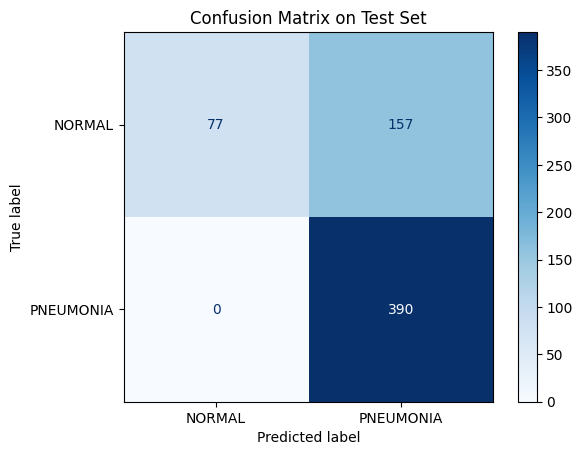


📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.33      0.50       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.66      0.66       624
weighted avg       0.82      0.75      0.71       624



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter

# ========== Config ==========
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 25
VAL_RATIO = 0.2
LEARNING_RATE = 1e-4
PREV_ACCURACY = 0.7692
DATA_DIR = "data/train"
TEST_DIR = "data/test"

THRESHOLD = 0.7  # Manual threshold for predicting pneumonia

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Transforms ==========
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ========== Dataset ==========
full_train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
num_classes = len(full_train_dataset.classes)
val_size = int(VAL_RATIO * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

# ======= Weighted Sampling to Handle Class Imbalance =======
labels = [full_train_dataset[i][1] for i in train_dataset.indices]
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ========== Model ==========
class PneumoniaClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(PneumoniaClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = PneumoniaClassifierCNN(num_classes).to(device)

# Optional: Xavier Initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)

# ========== Loss & Optimizer ==========
weights_tensor = torch.tensor([1.0 / np.log(1.2 + class_counts[i]) for i in range(len(class_counts))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# ========== Training Loop ==========
best_val_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"[Epoch {epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

# ========== Testing & Confusion Matrix ==========
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        predicted = (probs[:, 1] > THRESHOLD).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"📈 Improvement vs previous: {test_acc - PREV_ACCURACY:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

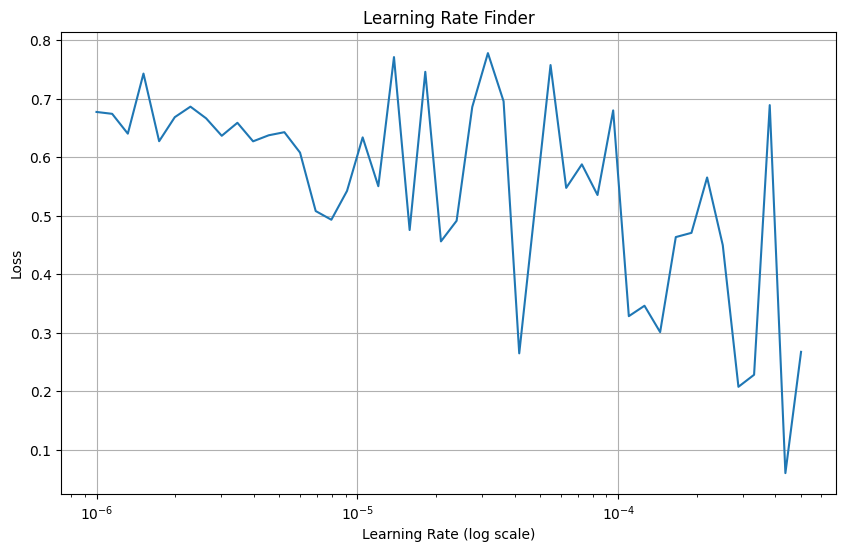

In [26]:
def lr_finder(model, train_loader, criterion, optimizer_class, device, start_lr=1e-6, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    # Exponential learning rate increase
    lr_lambda = lambda x: (end_lr / start_lr) ** (x / num_iter)
    optimizer = optimizer_class(model.parameters(), lr=start_lr)

    iter_count = 0
    best_loss = None
    for inputs, labels in train_loader:
        if iter_count > num_iter:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Record learning rate and loss
        lr = start_lr * lr_lambda(iter_count)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        lrs.append(lr)
        losses.append(loss.item())

        # Stop if loss explodes
        if best_loss is None or loss.item() < best_loss:
            best_loss = loss.item()
        if loss.item() > 4 * best_loss:
            break

        iter_count += 1

    return lrs, losses

def plot_lr_finder(lrs, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Finder")
    plt.grid(True)
    plt.show()


model = PneumoniaClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
train_loader_small = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

lrs, losses = lr_finder(
    model,
    train_loader_small,
    criterion,
    optimizer_class=optim.Adam,
    device=device,
    start_lr=1e-6,
    end_lr=1,
    num_iter=100
)

plot_lr_finder(lrs, losses)
